**решающее дерево**

Евгений Борисов <esborisov@sevsu.ru>

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

In [2]:
X_train,y_train = make_moons(n_samples=500,noise=.09)
X_train, X_test, y_train, y_test = train_test_split(X_train,y_train,test_size=.5)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((250, 2), (250,), (250, 2), (250,))

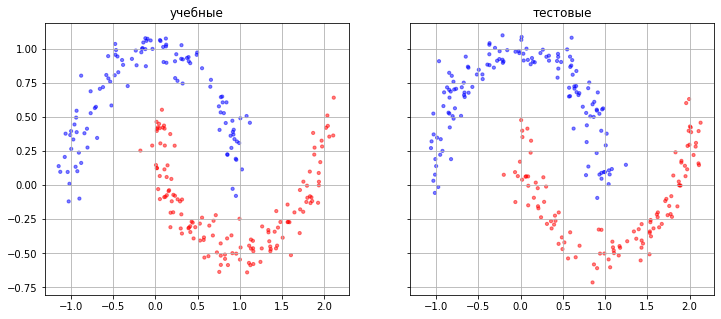

In [3]:
def plot_data(X,y,ax,t): 
    ax.scatter(x=X[:,0],y=X[:,1],c=np.array(['b','r'])[y],s=10,alpha=.5)
    ax.grid()
    ax.set_title(t)

fig,(ax0,ax1) = plt.subplots(1,2, sharey=True, sharex=True, figsize=(12,5),)
plot_data(X_train,y_train,ax0,'учебные')
plot_data(X_test,y_test,ax1,'тестовые')
plt.show()

**энтропийный критерий - информационный выигрыш (Information gain)**

Пусть ω0, ω1 — два исхода с вероятностями $q$ и $1−q$    

Количество информации:  
    $$I_0 = − log_2(q)$$  
    $$I_1 = − log_2(1 − q)$$ 

Энтропия - математическое ожидание количества информации:  

$$h(q) = −q \cdot log_2(q) − (1−q)\cdot log_2(1 − q)$$

Энтропия выборки $X$, если исходы — это классы $y=c$, $y\neq c$:
$$H(y) = h\left( \frac{P(y)}{S} \right)$$
P(y) - количество позитивных объектов класса y

S - общее количество объектов

Энтропия выборки $X$ после получения информации $R$: 

$$H(y|R)=\frac{p+n}{S} \cdot h\left(\frac{p}{p+n}\right) + \frac{S-p-n}{S} \cdot h\left( \frac{P(y)-p}{S-p-n} \right)$$


Информационный выигрыш (Information gain):
$$iGain(y,R) = H(y) − H(y|R)$$



- S - общее количество объектов
- P - количество положительных примеров
- p - количество положительных примеров, выделеных предикатом
- n - количество отрицательных примеров, выделеных предикатом




In [4]:
# энтропийный критерий - информационный выигрыш (Information gain, IGain):
def h(q):
    with np.errstate(divide='ignore',invalid='ignore'):
        l1 = np.where(q>0, q*np.log2(q), 0. )    
        l2 = np.where(q<1., (1.-q)*np.log2(1.-q), 0. )    
    return -l1 - l2

# разница в информативности, до и после примения предиката
def igain(S,P_y,p,n):
    # S - количество примеров
    # P_y - количество положительных в классе y
    # p - количество положительных примеров, выделенных предикатом   
    # n - количество отрицательных примеров, выделенных предикатом
    return h(P_y/S) - ( (p+n)/S * h(p/(p+n)) + (S-p-n)/S * h( (P_y-p)/(S-p-n)) )

# считаем информативность предиката x>b для разметки y
def info(x,y,b):
    S = len(y) # общее количество примеров
    P_all = y.sum() # количество положительных примеров
    f = x>b #  отмечаем примеры выделенные предикатом 
    p = (y[f]==1).sum() # количество положительных примеров, выделенных предикатом   
    n = (y[f]==0).sum() # количество отрицательных примеров, выделенных предикатом
    return igain(S,P_all,p,n) # разница в информативности

Алгоритм обучения выглядит следующим образом.

1. если X содержит точки только одного класса то создать лист с меткой класса и переход на п.6

2. выбрать признак номер $i$ и найти для него пороговое значение $b$, $(min(X_i) < b < max(X_i) )$ с максимальной информативностью разделения

3. создать узел дерева и сохранить там найденную пару $(i,b)$

4. разделить $X$ на две части по признаку $i$ и его порогу $b$

5. выполнить рекурсивно с п.1 для каждого полученного на пред.шаге подмножества

6. конец работы

In [5]:
# подбираем признак и его порог для разделения датасета (X,y) с максимальной информативностью
def search_split(X,y,nb=30): # np - количество порогов для перебора
    b = np.vstack([  # список порогов для каждого признака
        np.linspace( X[:,i].min(), X[:,i].max(), nb )[1:-1] 
        for i in range(X.shape[1]) 
    ])
    
    split_inf = np.array([ # матрица информативности для всех признаков их кандидатов в пороги 
        [ info(X[:,i],y,b[i,j]) for i in range(X.shape[1])  ]
        for j in range(b.shape[1]) 
    ])

    # индексы максимального значения в матрице информативности
    j,i = np.unravel_index(split_inf.argmax(),split_inf.shape)

    # результаты - параметры разбиения с максимальной информативностью
    return (
        i, # номер признака
        b[i,j], # порог
        split_inf[j,i], # значение информативности 
    )

In [6]:
from collections import Counter
def id3(X,y,nc=Counter('node')): # строим решающее дерево
    nc['node']+=1
    if (y==1).all() or (y==0).all(): # если разбиение содержит точки одного класса
        return { # то создаём лист с меткой класса
            'type':'leaf', # тип - лист
            'id': 'node%i'%(nc['node']), # номер узла
            'value':y[0] # номер класса в листе дерева
        } 
    i,b,si = search_split(X,y) # ищем оптимальное разделение по признаку
    f = X[:,i]>b # метки разбиения для датасета X (помечаем примеры, которые выделяет предикат)
    return {  # создаём узел дерева
        'type':'split',# тип - промежуточный узел
        'id': 'node%i'%(nc['node']), # номер узла
        'feature':i, # номер признака для применения порога
        'threshold':b, # порог разбиения для признака
        'info':si, # информативность разбиения
        '<': id3(X[~f,:],y[~f]), # разбиваем датасет ...
        '>': id3(X[f,:],y[f])   # ... и повторяем рекурсивно для двух частей
    }

tree = id3(X_train,y_train)

In [7]:
tree

{'type': 'split',
 'id': 'node1',
 'feature': 1,
 'threshold': 0.0709551354635809,
 'info': 0.41774028627467275,
 '<': {'type': 'split',
  'id': 'node2',
  'feature': 0,
  'threshold': -0.8217068425913858,
  'info': 0.13817065189143404,
  '<': {'type': 'leaf', 'id': 'node3', 'value': 0},
  '>': {'type': 'split',
   'id': 'node4',
   'feature': 1,
   'threshold': -0.07935301318616694,
   'info': 0.053230418703598736,
   '<': {'type': 'leaf', 'id': 'node5', 'value': 1},
   '>': {'type': 'split',
    'id': 'node6',
    'feature': 0,
    'threshold': 0.29586733612096405,
    'info': 0.16594919445169531,
    '<': {'type': 'leaf', 'id': 'node7', 'value': 1},
    '>': {'type': 'split',
     'id': 'node8',
     'feature': 0,
     'threshold': 0.9853401025921211,
     'info': 0.863120568566631,
     '<': {'type': 'leaf', 'id': 'node9', 'value': 0},
     '>': {'type': 'leaf', 'id': 'node10', 'value': 1}}}}},
 '>': {'type': 'split',
  'id': 'node11',
  'feature': 0,
  'threshold': 1.2136819243008

In [8]:
# рисуем дерево

import graphviz

dot = graphviz.Digraph()
dot.attr(size='6,7')
dot.node('root','start',color='yellow',style='filled')

def plot_tree(tree,dot,root='root'):
    node=tree['id']
    if tree['type']=='split':
        label = r'{id}    \rx[{feature}]>{threshold:.3f}\rinfo:{info:.3f}'.format(**tree)
        dot.node(node,label,color='lightgray',style='filled')
        plot_tree(tree=tree['>'],dot=dot,root=node)
        plot_tree(tree=tree['<'],dot=dot,root=node)
    else:
        label = '%i'%tree['value']
        c = ['lightskyblue','lightcoral'][tree['value']]
        dot.node(node,label,color=c,style='filled')
        
    dot.edge(root,node)
    return dot 

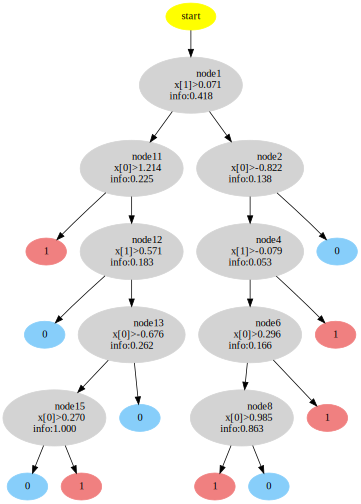

In [9]:
plot_tree(tree,dot)

In [10]:
# конвертируем дерево в список правил
def tree2rules(node,paths=[],path=[],cond=None):
    if node['type']=='leaf':
        path.append(cond)
        path.append(node['value'])
        paths.append(path)
        return paths
    path.append(cond)
    tree2rules(node=node['>'],paths=paths,path=path.copy(),cond=(node['feature'],'>',node['threshold']))
    tree2rules(node=node['<'],paths=paths,path=path.copy(),cond=(node['feature'],'<',node['threshold']))
    return paths

In [11]:
# собиреем все пути от корня к листам positive
rules = [ p[1:-1] for p in tree2rules(tree) if p[-1]==1 ] 
rules

[[(1, '>', 0.0709551354635809), (0, '>', 1.2136819243008499)],
 [(1, '>', 0.0709551354635809),
  (0, '<', 1.2136819243008499),
  (1, '<', 0.5713571919984581),
  (0, '>', -0.6763524794159238),
  (0, '<', 0.26986664845804703)],
 [(1, '<', 0.0709551354635809),
  (0, '>', -0.8217068425913858),
  (1, '>', -0.07935301318616694),
  (0, '>', 0.29586733612096405),
  (0, '>', 0.9853401025921211)],
 [(1, '<', 0.0709551354635809),
  (0, '>', -0.8217068425913858),
  (1, '>', -0.07935301318616694),
  (0, '<', 0.29586733612096405)],
 [(1, '<', 0.0709551354635809),
  (0, '>', -0.8217068425913858),
  (1, '<', -0.07935301318616694)]]

In [13]:
from IPython.display import Math, display
display(Math(
    '$$'+
    '\n \\lor '.join([
        '\\left['+' \\land '.join([ '(x_%i %s %.2f)'%(p) for p in predicates ])+'\\right]'
        for predicates in rules
    ])
    +'$$'
))

<IPython.core.display.Math object>

In [14]:
# применяем список правил 
def predict(X,rules):
    apply = lambda x,p: x[:,p[0]]>p[2] if p[1]=='>' else x[:,p[0]]<p[2]
    return np.vstack([ 
         np.vstack([ apply(X,p) for p in predicates ]).all(axis=0) # AND для одной ветки от корня до листа
         for predicates in rules # OR для всех веток от корня до листа (только positive)
        ]).any(axis=0).astype(int)

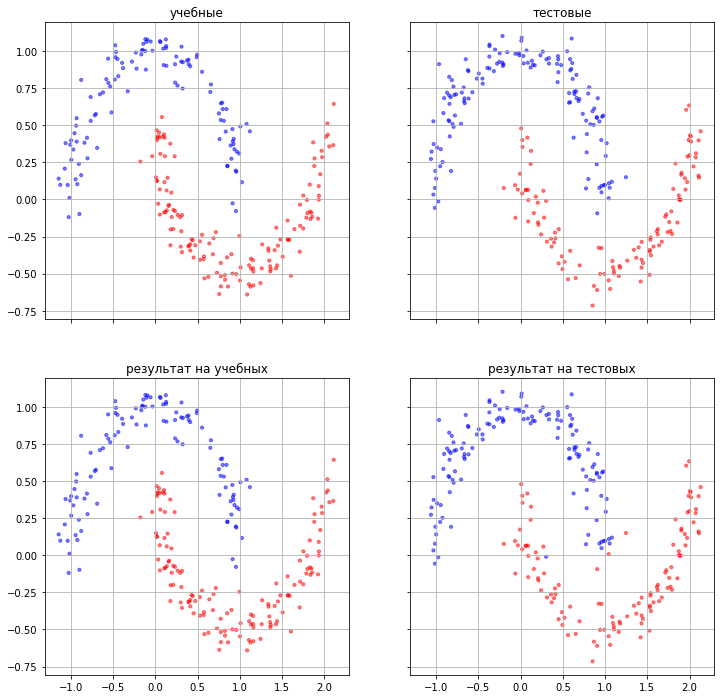

In [15]:
fig,( (ax0,ax1),(ax2,ax3) ) = plt.subplots(2,2, sharey=True, sharex=True, figsize=(12,12),)
plot_data(X_train,y_train,ax0,'учебные')
plot_data(X_test,y_test,ax1,'тестовые')

o_train = predict(X_train,rules)
o_test = predict(X_test,rules)

plot_data(X_train,o_train,ax2,'результат на учебных')
plot_data(X_test,o_test,ax3,'результат на тестовых')

plt.show()

In [16]:
from sklearn.metrics import classification_report

# метрики результата на тестовом наборе
print( classification_report(y_test,o_test) )

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       138
           1       0.97      0.99      0.98       112

    accuracy                           0.98       250
   macro avg       0.98      0.98      0.98       250
weighted avg       0.98      0.98      0.98       250



In [17]:
# метрики результата на учёбном наборе
print( classification_report(y_train,o_train) )

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       112
           1       1.00      1.00      1.00       138

    accuracy                           1.00       250
   macro avg       1.00      1.00      1.00       250
weighted avg       1.00      1.00      1.00       250



----

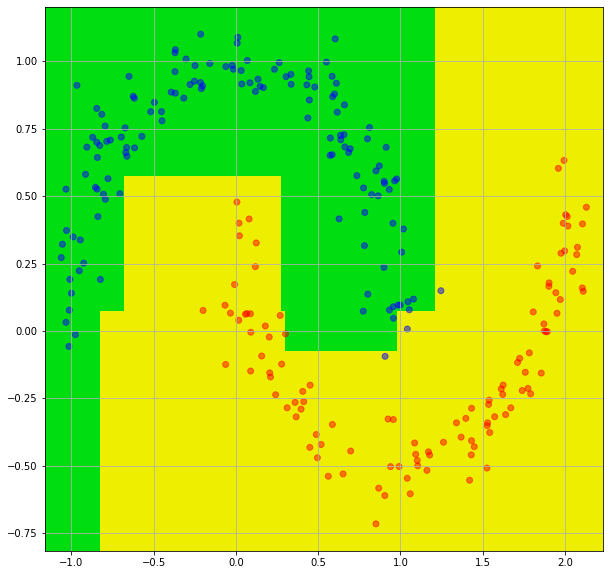

In [18]:
# строим сетку и определяем значения скора классификатора во всех узлах

n=500 # количество разбиений сетки
xx,yy = np.meshgrid( # узлы сетки
    np.linspace( X_test[:,0].min()-0.1, X_test[:,0].max()+0.1, n), 
    np.linspace( X_test[:,1].min()-0.1, X_test[:,1].max()+0.1, n)
) 
xy = np.vstack([xx.ravel(),yy.ravel() ]).T # разворачиваем сетку 

rr = predict(xy,rules).reshape(n,n) # применяем классификатор для каждого узла сетки
    
from matplotlib.colors import ListedColormap
cm=ListedColormap(['#00dd11','#eeee00'])
plt.figure(figsize=(10,10))
plt.contourf(xx, yy, rr, cmap=cm)
c = [ ['b','r'][ j ] for j in y_test  ]
plt.scatter( x=X_test[:,0], y=X_test[:,1], c=c, alpha=.5 )
plt.grid()
plt.show()